In [1]:
import torch
from torch import nn
import torch
import torchvision.datasets as datasets  # Standard datasets
from torchvision import transforms
from torchvision.utils import save_image
from matplotlib import pyplot as plt

# Select the latent space dimension you want to play with
Z_DIM = 20

In [2]:
INPUT_DIM = 784
H_DIM = 200

class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=H_DIM, z_dim=Z_DIM):
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self, x):
        mu, sigma = self.encode(x)
        # reparametrization trick
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma*epsilon
        x_reconstructed = self.decode(z_new)
        return x_reconstructed, mu, sigma


In [3]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

# Dataset Loading
dataset = datasets.FashionMNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)

In [4]:
Z_DIM

20

In [5]:
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)

# Load the saved parameters into the new model
model.load_state_dict(torch.load(f'output/FashionMNIST/model_{Z_DIM}.pth'))

# Set the model to evaluation mode if you intend to use it for inference
model.eval()

VariationalAutoEncoder(
  (img_2hid): Linear(in_features=784, out_features=200, bias=True)
  (hid_2mu): Linear(in_features=200, out_features=20, bias=True)
  (hid_2sigma): Linear(in_features=200, out_features=20, bias=True)
  (z_2hid): Linear(in_features=20, out_features=200, bias=True)
  (hid_2img): Linear(in_features=200, out_features=784, bias=True)
  (relu): ReLU()
)

In [6]:
def inference_all(num_examples=1):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.

    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    images = []
    idx = 0
    # save one image for each label
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    # encode each of the 10 image
    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
            sigma = torch.abs(sigma)
            #print(sigma)
            torch.save(mu, f'output/FashionMNIST/MU/mu_{d}_{Z_DIM}.pth')
            torch.save(sigma, f'output/FashionMNIST/SIGMA/sigma_{d}_{Z_DIM}.pth')
        encodings_digit.append((mu, sigma))

    for digit in range(10):
        mu, sigma = encodings_digit[digit]
        for example in range(num_examples):
            epsilon = torch.randn_like(sigma)
            z = mu + sigma * epsilon
            out = model.decode(z)
            out = out.view(-1, 1, 28, 28)
            save_image(out, f"output/FashionMNIST/GENERATED/generated_{digit}_ex{example}_z{Z_DIM}.png")
    
    return images, encodings_digit


images, encodings_digit = inference_all(num_examples=1)

In [7]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define the batch size for the test DataLoader
TEST_BATCH_SIZE = 32  

# Load the FashionMNIST test dataset
test_dataset = datasets.FashionMNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)

# Create a DataLoader for the test dataset
test_loader = DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot

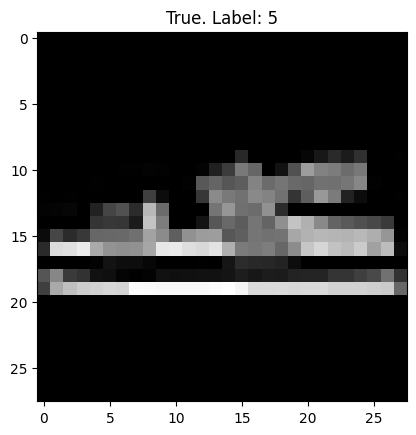

In [8]:
# Set random seed for reproducibility
#seed = 41
#torch.manual_seed(seed)

# Choose a batch of images
data_iterator = iter(test_loader)
images, labels = next(data_iterator)

# Display the first image from the batch
image = images[0].squeeze().numpy()  # Squeeze to remove the channel dimension and convert to a NumPy array
plt.imshow(image, cmap='gray')
plt.title(f"True. Label: {labels[0]}")
plt.show()

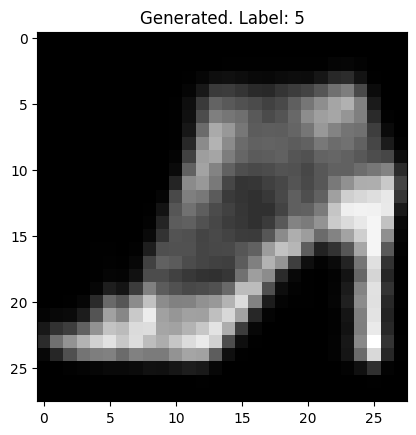

In [9]:
# how the model generates

mu = torch.load(f'output/FashionMNIST/MU/mu_{labels[0]}_{Z_DIM}.pth')
sigma = torch.load(f'output/FashionMNIST/SIGMA/sigma_{labels[0]}_{Z_DIM}.pth')

epsilon = torch.randn_like(sigma)
z = mu + sigma * epsilon
out = model.decode(z)
out = out.view(-1, 1, 28, 28)


image = out.squeeze().cpu().detach().numpy()  # Squeeze to remove the channel dimension and convert to a NumPy array
plt.imshow(image, cmap='gray')
plt.title(f"Generated. Label: {labels[0]}")
plt.show()

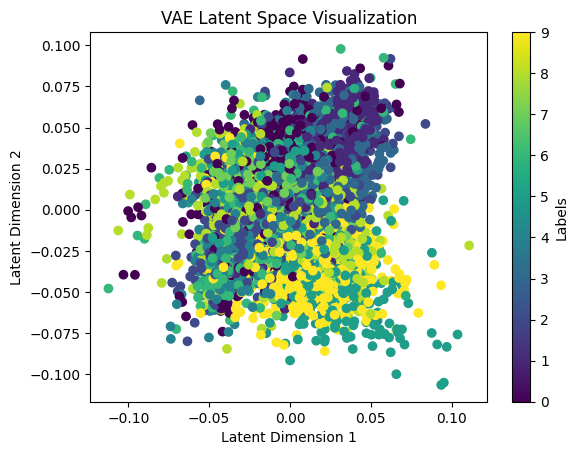

In [10]:
import numpy as np
from sklearn.decomposition import PCA

for i, (x, labels) in enumerate(test_loader):

    x = x.to(DEVICE).view(x.shape[0], INPUT_DIM)
    mu, _ = model.encode(x)
    mu = mu.detach().numpy()
    #mu = PCA(n_components=2).fit_transform(mu)
    
    plt.scatter(mu[:,0], mu[:, 1], c=labels)
    
plt.colorbar(label='Labels')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('VAE Latent Space Visualization')
plt.show()


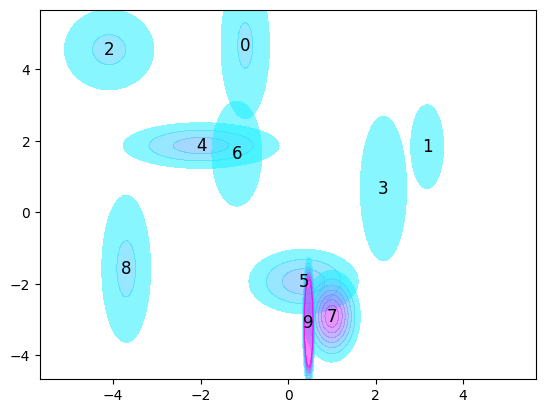

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from   scipy.stats import multivariate_normal

MU = []
SIGMA = []
for i in range(10):
    MU.append(torch.load(f'output/FashionMNIST/MU/mu_{i}_2.pth').numpy())
    SIGMA.append(torch.load(f'output/FashionMNIST/SIGMA/sigma_{i}_2.pth').numpy())

MU = np.squeeze(np.array(MU), axis=1)
SIGMA = np.squeeze(np.array(SIGMA), axis=1)

N    = 500
X    = np.linspace(-np.max(abs(MU))-1, np.max(abs(MU))+1, N)
Y    = np.linspace(-np.max(abs(MU)), np.max(abs(MU))+1, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))

plt.set_cmap('cool')

for i in range(10):
    rv   = multivariate_normal(MU[i], [[SIGMA[i][0], 0], [0, SIGMA[i][1]]])
    Z    = rv.pdf(pos)
    plt.contourf(X, Y, Z, 
                levels=[.1,.2,.3,.4,.5,.6,.7,.8,.9],
                alpha=.5,
                extend='max'
                )
    
    plt.text(MU[i][0], MU[i][1], str(i), fontsize=12, color='black', ha='center', va='center')

    
plt.show()